<a href="https://colab.research.google.com/github/akshat2635/sentiment-analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format

Dataset URL: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format
License(s): world-bank
 74% 19.0M/25.7M [00:00<00:00, 94.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 109MB/s] 


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/imdb-dataset-sentiment-analysis-in-csv-format.zip', 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [4]:
train=pd.read_csv('/content/data/Train.csv')
val=pd.read_csv('/content/data/Valid.csv')
test=pd.read_csv('/content/data/Test.csv')
train

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [5]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize, word_tokenize
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
def preprocess(text):
  text=text.lower()
  tokens=word_tokenize(text)
  preprocessed_text=simple_preprocess(remove_stopwords(' '.join(tokens)))
  return preprocessed_text
print(train['text'][0])
print(preprocess(train['text'][0]))

I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.
['grew', 'watching', 'loving', 'thunderbirds', 'mates', 'school', 'watched', 'played', 'thunderbirds', 'school', 'lunch', 'sc

In [7]:
train.drop_duplicates(inplace=True)
val.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

In [8]:
train['text']=train['text'].apply(preprocess)
val['text']=val['text'].apply(preprocess)
test['text']=test['text'].apply(preprocess)

In [9]:
train

,text,label
0,"[grew, watching, loving, thunderbirds, mates, ...",0
1,"[movie, dvd, player, sat, coke, chips, expecta...",0
2,"[people, know, particular, time, past, like, f...",0
3,"[great, biblical, movies, bored, death, minute...",0
4,"[im, die, hard, dads, army, fan, change, got, ...",1
...,...,...
39995,"[western, union, forgotten, classic, western, ...",1
39996,"[movie, incredible, piece, work, explores, noo...",1
39997,"[wife, watched, movie, plan, visit, sicily, st...",0
39998,"[watched, flatliners, amazed, necessary, featu...",1


In [ ]:
corpus=[]
for i in range(len(train)):
  corpus.append(train['text'].iloc[i])
for i in range(len(val)):
  corpus.append(val['text'].iloc[i])

In [ ]:
len(corpus)

44721

In [ ]:
model=Word2Vec(min_count=2,vector_size=200,window=3,workers=4)
model.build_vocab(corpus)

In [ ]:
len(model.wv.key_to_index)

59298

In [ ]:
model.train(corpus,total_examples=model.corpus_count,epochs=10)

(44773159, 48151170)

In [ ]:
def sentence_vector(sentence, model):
    # Filter words that are in the Word2Vec vocabulary
    words = [word for word in sentence if word in model.wv]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    # Average the Word2Vec vectors of the words
    return np.mean(model.wv[words], axis=0)

# Convert the entire dataset
X_train = np.array([sentence_vector(sentence, model) for sentence in train['text']])
y_train = np.array(train['label'])
X_val = np.array([sentence_vector(sentence, model) for sentence in val['text']])
y_val = np.array(val['label'])
X_test = np.array([sentence_vector(sentence, model) for sentence in test['text']])
y_test = np.array(test['label'])

In [ ]:
X_train.shape

(39723, 200)

In [ ]:
sample_indices=np.random.permutation(X_train.shape[0])[:10000]
X_train_sampled=X_train[sample_indices]
y_train_sampled=y_train[sample_indices]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Accuracy for n=100: 82.76%
Accuracy for n=250: 83.58%
Accuracy for n=500: 83.24%
Accuracy for n=750: 83.68%


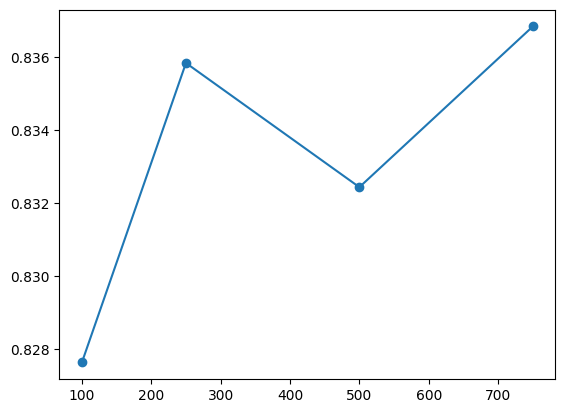

In [ ]:
# Define hyperparameter grid for Random Forest
n_values=[100,250,500,750]
accuracies=[]
for i in n_values:
    random_forest_model=RandomForestClassifier(n_estimators=i)

    random_forest_model.fit(X_train_sampled,y_train_sampled)
    y_pred=random_forest_model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print( f"Accuracy for n={i}:",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
    # print("\nClassification Report:\n", classification_report(y_test, y_pred))
plt.plot(n_values,accuracies,marker='o')

In [ ]:
grid={'est':[100,200,500,1000],
'max_depth': [3, 6, 10],
'learning_rate': [0.01, 0.1]}
accuracies=[]
for i in grid['est']:
  for j in grid['max_depth']:
    for k in grid['learning_rate']:
      xgb_model=xgb.XGBClassifier(n_estimators=i,max_depth=j,learning_rate=k);

      xgb_model.fit(X_train_sampled,y_train_sampled)
      y_pred=xgb_model.predict(X_test)
      acc=accuracy_score(y_test, y_pred)
      accuracies.append(acc)
      print( f"Accuracy for est={i} max_depth={j} learning_rate={k}:",  "{:.2f}%".format(accuracy_score(y_test, y_pred)*100))
    # print("\nClassification Report:\n", classification_report(y_test, y_pred))
# plt.plot(n_values,accuracies,marker='o')

Accuracy for est=100 max_depth=3 learning_rate=0.01: 78.46%
Accuracy for est=100 max_depth=3 learning_rate=0.1: 84.16%
Accuracy for est=100 max_depth=6 learning_rate=0.01: 81.38%
Accuracy for est=100 max_depth=6 learning_rate=0.1: 84.54%
Accuracy for est=100 max_depth=10 learning_rate=0.01: 81.78%
Accuracy for est=100 max_depth=10 learning_rate=0.1: 84.42%
Accuracy for est=200 max_depth=3 learning_rate=0.01: 80.58%
Accuracy for est=200 max_depth=3 learning_rate=0.1: 84.80%
Accuracy for est=200 max_depth=6 learning_rate=0.01: 82.82%
Accuracy for est=200 max_depth=6 learning_rate=0.1: 85.27%
Accuracy for est=200 max_depth=10 learning_rate=0.01: 82.86%
Accuracy for est=200 max_depth=10 learning_rate=0.1: 85.01%
Accuracy for est=500 max_depth=3 learning_rate=0.01: 83.28%
Accuracy for est=500 max_depth=3 learning_rate=0.1: 85.73%
Accuracy for est=500 max_depth=6 learning_rate=0.01: 84.54%
Accuracy for est=500 max_depth=6 learning_rate=0.1: 85.41%
Accuracy for est=500 max_depth=10 learning_r

In [54]:
corpus=[]
for i in range(len(train)):
  corpus+=train['text'].iloc[i]
for i in range(len(val)):
  corpus+=val['text'].iloc[i]

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(corpus)

In [12]:
len(tokenizer.word_index)

95197

In [53]:
import json
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [13]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json

In [ ]:
with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer1 = tokenizer_from_json(data)
len(tokenizer1.word_index)

95214

In [14]:
def toseq(text):
  return tokenizer.texts_to_sequences([text])[0]
train['seq']=train['text'].apply(toseq)
val['seq']=val['text'].apply(toseq)
test['seq']=test['text'].apply(toseq)

In [15]:
max_len=max(train['seq'].apply(len))
max_len

1293

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def padding(text):
  return pad_sequences([text],maxlen=max_len,padding='pre')[0]
train['seq']=train['seq'].apply(padding)
val['seq']=val['seq'].apply(padding)
test['seq']=test['seq'].apply(padding)


In [17]:
X=np.array([list(i) for i in train['seq']])
y=train['label']
X_val=np.array([list(i) for i in val['seq']])
y_val=val['label']

In [18]:
X.shape

(39723, 1293)

In [ ]:
print({arr.shape for arr in X_val})

{(2380,)}


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,GRU,BatchNormalization,Dropout,Bidirectional
from tensorflow import keras

In [35]:
Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.4,patience=2,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

In [36]:
basic_lstm=Sequential()
basic_lstm.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=200,input_shape=(max_len-1,)))

basic_lstm.add(LSTM(150))

basic_lstm.add(Dense(1,activation='sigmoid'))
basic_lstm.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

basic_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 1292, 200)           │      19,039,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 150)                 │         210,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,250,351 (73.43 MB)

 Trainable params: 19,250,351 (73.43 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
basic_lstm.fit(X,y,epochs=10,batch_size=256,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 44s 273ms/step - accuracy: 0.7151 - loss: 0.5501 - val_accuracy: 0.8890 - val_loss: 0.2743 - learning_rate: 0.0010
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 81s 270ms/step - accuracy: 0.9354 - loss: 0.1798 - val_accuracy: 0.8848 - val_loss: 0.2840 - learning_rate: 0.0010
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9704 - loss: 0.0910
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
156/156 ━━━━━━━━━━━━━━━━━━━━ 82s 267ms/step - accuracy: 0.9704 - loss: 0.0910 - val_accuracy: 0.8774 - val_loss: 0.3215 - learning_rate: 0.0010
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 82s 268ms/step - accuracy: 0.9872 - loss: 0.0467 - val_accuracy: 0.8860 - val_loss: 0.4537 - learning_rate: 4.0000e-04
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9946 - loss: 0.0220
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
156/156 ━━━━━━━━━━━━━━━━━━━━ 82s 267ms/step - accuracy: 0.

In [38]:
basic_lstm.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8895 - loss: 0.2795


[0.2737677991390228, 0.8914914727210999]

In [40]:
Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.4,patience=2,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

ann_lstm=Sequential()
ann_lstm.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=200,input_shape=(max_len-1,)))

ann_lstm.add(LSTM(150,dropout=0.4))

ann_lstm.add(Dense(64,activation='relu'))
ann_lstm.add(BatchNormalization())
ann_lstm.add(Dropout(0.4))

ann_lstm.add(Dense(32,activation='relu'))
ann_lstm.add(BatchNormalization())
ann_lstm.add(Dropout(0.4))

ann_lstm.add(Dense(1,activation='sigmoid'))
ann_lstm.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

ann_lstm.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 1292, 200)           │      19,039,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 150)                 │         210,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           9,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,262,361 (73.48 MB)

 Trainable params: 19,262,169 (73.48 MB)

 Non-trainable params: 192 (768.00 B)

In [41]:
ann_lstm.fit(X,y,epochs=10,batch_size=256,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 47s 285ms/step - accuracy: 0.6450 - loss: 0.6768 - val_accuracy: 0.8487 - val_loss: 0.5566 - learning_rate: 0.0010
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 81s 277ms/step - accuracy: 0.9135 - loss: 0.2334 - val_accuracy: 0.8597 - val_loss: 0.3468 - learning_rate: 0.0010
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 42s 271ms/step - accuracy: 0.9584 - loss: 0.1249 - val_accuracy: 0.8725 - val_loss: 0.3171 - learning_rate: 0.0010
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 83s 278ms/step - accuracy: 0.9710 - loss: 0.0897 - val_accuracy: 0.8752 - val_loss: 0.3835 - learning_rate: 0.0010
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9807 - loss: 0.0611
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
156/156 ━━━━━━━━━━━━━━━━━━━━ 81s 275ms/step - accuracy: 0.9806 - loss: 0.0611 - val_accuracy: 0.8593 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 82s 276ms/step - accuracy: 0.989

In [42]:
ann_lstm.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8734 - loss: 0.5114


[0.5060445070266724, 0.875075101852417]

In [43]:
Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8, restore_best_weights = True, verbose=1)
Reducing_LR = keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.4,patience=2,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

basic_gru=Sequential()
basic_gru.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=200,input_shape=(max_len-1,)))

basic_gru.add(GRU(150,dropout=0.4))

basic_gru.add(Dense(1,activation='sigmoid'))
basic_gru.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

basic_gru.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 1292, 200)           │      19,039,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 150)                 │         158,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,198,151 (73.24 MB)

 Trainable params: 19,198,151 (73.24 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
basic_gru.fit(X,y,epochs=10,batch_size=256,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - accuracy: 0.6530 - loss: 0.6128 - val_accuracy: 0.8459 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.8954 - loss: 0.2613 - val_accuracy: 0.8830 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 234ms/step - accuracy: 0.9511 - loss: 0.1351 - val_accuracy: 0.8814 - val_loss: 0.3229 - learning_rate: 0.0010
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9758 - loss: 0.0721
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
156/156 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.9758 - loss: 0.0721 - val_accuracy: 0.8826 - val_loss: 0.3785 - learning_rate: 0.0010
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.9912 - loss: 0.0308 - val_accuracy: 0.8812 - val_loss: 0.4199 - learning_rate: 4.0000e-04
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.

In [45]:
basic_gru.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8843 - loss: 0.3054


[0.30392131209373474, 0.8824824690818787]

In [46]:
Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8, restore_best_weights = True, verbose=1)
Reducing_LR = keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.4,patience=2,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

ann_gru=Sequential()
ann_gru.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=200,input_shape=(max_len-1,)))

ann_gru.add(GRU(150,dropout=0.4))

ann_gru.add(Dense(64,activation='relu'))
ann_gru.add(BatchNormalization())
ann_gru.add(Dropout(0.4))

ann_gru.add(Dense(32,activation='relu'))
ann_gru.add(BatchNormalization())
ann_gru.add(Dropout(0.4))

ann_gru.add(Dense(1,activation='sigmoid'))
ann_gru.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

ann_gru.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)              │ (None, 1292, 200)           │      19,039,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 150)                 │         158,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           9,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,210,161 (73.28 MB)

 Trainable params: 19,209,969 (73.28 MB)

 Non-trainable params: 192 (768.00 B)

In [47]:
ann_gru.fit(X,y,epochs=10,batch_size=256,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 40s 234ms/step - accuracy: 0.5650 - loss: 0.8273 - val_accuracy: 0.5710 - val_loss: 0.6599 - learning_rate: 0.0010
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.8831 - loss: 0.2896 - val_accuracy: 0.8095 - val_loss: 0.4048 - learning_rate: 0.0010
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.9533 - loss: 0.1408 - val_accuracy: 0.8770 - val_loss: 0.3228 - learning_rate: 0.0010
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.9737 - loss: 0.0855 - val_accuracy: 0.8715 - val_loss: 0.3709 - learning_rate: 0.0010
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9818 - loss: 0.0612
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.9817 - loss: 0.0612 - val_accuracy: 0.8651 - val_loss: 0.4496 - learning_rate: 0.0010
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.987

In [48]:
ann_gru.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8632 - loss: 0.3493


[0.3444419503211975, 0.8690690398216248]

In [ ]:
gru_model=Sequential()
gru_model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=200,input_shape=(max_len-1,)))

gru_model.add(GRU(150,dropout=0.5,return_sequences=True))
gru_model.add(GRU(150,dropout=0.5,return_sequences=True))
gru_model.add(GRU(150,dropout=0.5))

gru_model.add(Dense(128,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.5))

gru_model.add(Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.5))

gru_model.add(Dense(32,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.5))

gru_model.add(Dense(1,activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])


In [ ]:
gru_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 1292, 200)           │      19,039,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_12 (GRU)                         │ (None, 1292, 150)           │         158,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ (None, 1292, 150)           │         135,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_14 (GRU)                         │ (None, 150)                 │         135,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          19,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,500,393 (74.39 MB)

 Trainable params: 19,499,945 (74.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
gru_model.fit(X,y,epochs=5,batch_size=128,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 115s 354ms/step - accuracy: 0.5019 - loss: 12.8412 - val_accuracy: 0.4970 - val_loss: 0.9513 - learning_rate: 0.0010
Epoch 2/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 142s 355ms/step - accuracy: 0.7093 - loss: 0.6888 - val_accuracy: 0.8770 - val_loss: 0.3829 - learning_rate: 0.0010
Epoch 3/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 142s 354ms/step - accuracy: 0.9190 - loss: 0.2519 - val_accuracy: 0.8475 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 4/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9559 - loss: 0.1585
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
311/311 ━━━━━━━━━━━━━━━━━━━━ 142s 356ms/step - accuracy: 0.9559 - loss: 0.1585 - val_accuracy: 0.8657 - val_loss: 0.4468 - learning_rate: 0.0010
Epoch 5/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 143s 358ms/step - accuracy: 0.9761 - loss: 0.0976 - val_accuracy: 0.8798 - val_loss: 0.4028 - learning_rate: 4.0000e-04
Restoring model weights from the end of the best epoch: 5.


In [20]:
X_test=np.array([list(i) for i in test['seq'].to_numpy()])
y_test=test['label']

In [ ]:
gru_model.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8768 - loss: 0.4054


[0.41350555419921875, 0.8780781030654907]

In [24]:
Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8, restore_best_weights = True, verbose=1)
Reducing_LR = keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.4,patience=2,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

bi_gru_model=Sequential()
bi_gru_model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=200,input_shape=(max_len-1,)))

bi_gru_model.add(Bidirectional(GRU(150,dropout=0.5,return_sequences=True)))
bi_gru_model.add(Bidirectional(GRU(150,dropout=0.5,return_sequences=True)))
bi_gru_model.add(GRU(150,dropout=0.5))

bi_gru_model.add(Dense(128,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
bi_gru_model.add(BatchNormalization())
bi_gru_model.add(Dropout(0.5))

bi_gru_model.add(Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
bi_gru_model.add(BatchNormalization())
bi_gru_model.add(Dropout(0.5))

bi_gru_model.add(Dense(32,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
bi_gru_model.add(BatchNormalization())
bi_gru_model.add(Dropout(0.5))

bi_gru_model.add(Dense(1,activation='sigmoid'))

bi_gru_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [25]:
bi_gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 1292, 200)           │      19,039,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1292, 300)           │         316,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 1292, 300)           │         406,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 150)                 │         203,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          19,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,997,193 (76.28 MB)

 Trainable params: 19,996,745 (76.28 MB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
bi_gru_model.fit(X,y,epochs=5,batch_size=256,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.4981 - loss: 16.9747 - val_accuracy: 0.4970 - val_loss: 2.4250 - learning_rate: 0.0010
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.6152 - loss: 1.6941 - val_accuracy: 0.7865 - val_loss: 0.7593 - learning_rate: 0.0010
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8887 - loss: 0.3739 - val_accuracy: 0.8709 - val_loss: 0.4932 - learning_rate: 0.0010
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9521 - loss: 0.1708 - val_accuracy: 0.8729 - val_loss: 0.3328 - learning_rate: 0.0010
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9700 - loss: 0.1210 - val_accuracy: 0.8693 - val_loss: 0.4096 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.


In [27]:
bi_gru_model.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.8757 - loss: 0.3355


[0.3377407193183899, 0.872272253036499]

In [28]:
Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8, restore_best_weights = True, verbose=1)
Reducing_LR = keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.4,patience=2,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

lstm_model=Sequential()
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=200,input_shape=(max_len-1,)))

lstm_model.add(LSTM(150,dropout=0.5,return_sequences=True))
lstm_model.add(LSTM(150,dropout=0.5,return_sequences=True))
lstm_model.add(LSTM(150,dropout=0.5))


lstm_model.add(Dense(128,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(32,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(1,activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 1292, 200)           │      19,039,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1292, 150)           │         210,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1292, 150)           │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          19,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,641,993 (74.93 MB)

 Trainable params: 19,641,545 (74.93 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
lstm_model.fit(X,y,epochs=5,batch_size=128,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 132s 408ms/step - accuracy: 0.5549 - loss: 12.5348 - val_accuracy: 0.4992 - val_loss: 0.8413 - learning_rate: 0.0010
Epoch 2/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 142s 409ms/step - accuracy: 0.8252 - loss: 0.5027 - val_accuracy: 0.4990 - val_loss: 0.7486 - learning_rate: 0.0010
Epoch 3/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 143s 414ms/step - accuracy: 0.4997 - loss: 0.7590 - val_accuracy: 0.5014 - val_loss: 0.7058 - learning_rate: 0.0010
Epoch 4/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 143s 417ms/step - accuracy: 0.5086 - loss: 0.7004 - val_accuracy: 0.4970 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 5/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 139s 408ms/step - accuracy: 0.4989 - loss: 0.6932 - val_accuracy: 0.5030 - val_loss: 0.6931 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [30]:
lstm_model.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.4836 - loss: 0.6933


[0.693151593208313, 0.50090092420578]

In [32]:
Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8, restore_best_weights = True, verbose=1)
Reducing_LR = keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.4,patience=2,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

bi_lstm_model=Sequential()
bi_lstm_model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=200,input_shape=(max_len-1,)))

bi_lstm_model.add(Bidirectional(LSTM(150,dropout=0.5,return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(100,dropout=0.5,return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(50,dropout=0.5)))

bi_lstm_model.add(Dense(128,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
bi_lstm_model.add(BatchNormalization())
bi_lstm_model.add(Dropout(0.5))

bi_lstm_model.add(Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
bi_lstm_model.add(BatchNormalization())
bi_lstm_model.add(Dropout(0.5))

bi_lstm_model.add(Dense(32,activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
bi_lstm_model.add(BatchNormalization())
bi_lstm_model.add(Dropout(0.5))

bi_lstm_model.add(Dense(1,activation='sigmoid'))

bi_lstm_model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

bi_lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 1292, 200)           │      19,039,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 1292, 300)           │         421,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 1292, 200)           │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 100)                 │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,906,193 (75.94 MB)

 Trainable params: 19,905,745 (75.93 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
bi_lstm_model.fit(X,y,epochs=5,batch_size=128,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 235s 729ms/step - accuracy: 0.4938 - loss: 12.1973 - val_accuracy: 0.4970 - val_loss: 1.0016 - learning_rate: 0.0010
Epoch 2/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 225s 725ms/step - accuracy: 0.5311 - loss: 0.8723 - val_accuracy: 0.7225 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 3/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 262s 726ms/step - accuracy: 0.8497 - loss: 0.4027 - val_accuracy: 0.8507 - val_loss: 0.4496 - learning_rate: 0.0010
Epoch 4/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 262s 726ms/step - accuracy: 0.9341 - loss: 0.2277 - val_accuracy: 0.8798 - val_loss: 0.3691 - learning_rate: 0.0010
Epoch 5/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 262s 727ms/step - accuracy: 0.9635 - loss: 0.1425 - val_accuracy: 0.8770 - val_loss: 0.4395 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.


In [34]:
bi_lstm_model.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.8776 - loss: 0.3734


[0.361609548330307, 0.8830831050872803]

In [49]:
Early_Stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 8, restore_best_weights = True, verbose=1)
Reducing_LR = keras.callbacks.ReduceLROnPlateau( monitor='val_loss',factor=0.4,patience=2,verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

lstm_gru=Sequential()
lstm_gru.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=200,input_shape=(max_len-1,)))

lstm_gru.add(GRU(150,dropout=0.4,return_sequences=True))
lstm_gru.add(LSTM(150,dropout=0.4,return_sequences=True))
lstm_gru.add(LSTM(100,dropout=0.4,return_sequences=True))
lstm_gru.add(GRU(100,dropout=0.4))

lstm_gru.add(Dense(64,activation='relu'))
lstm_gru.add(BatchNormalization())
lstm_gru.add(Dropout(0.4))

lstm_gru.add(Dense(32,activation='relu'))
lstm_gru.add(BatchNormalization())
lstm_gru.add(Dropout(0.4))

lstm_gru.add(Dense(1,activation='sigmoid'))
lstm_gru.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

lstm_gru.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 1292, 200)           │      19,039,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 1292, 150)           │         158,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 1292, 150)           │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 1292, 100)           │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 100)                 │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,548,561 (74.57 MB)

 Trainable params: 19,548,369 (74.57 MB)

 Non-trainable params: 192 (768.00 B)

In [50]:
lstm_gru.fit(X,y,epochs=5,batch_size=128,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 141s 438ms/step - accuracy: 0.5682 - loss: 0.7735 - val_accuracy: 0.8589 - val_loss: 0.3413 - learning_rate: 0.0010
Epoch 2/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 136s 420ms/step - accuracy: 0.8912 - loss: 0.2805 - val_accuracy: 0.8703 - val_loss: 0.3203 - learning_rate: 0.0010
Epoch 3/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 142s 420ms/step - accuracy: 0.9401 - loss: 0.1724 - val_accuracy: 0.8619 - val_loss: 0.3610 - learning_rate: 0.0010
Epoch 4/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9669 - loss: 0.1054
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
311/311 ━━━━━━━━━━━━━━━━━━━━ 131s 420ms/step - accuracy: 0.9669 - loss: 0.1055 - val_accuracy: 0.8723 - val_loss: 0.3544 - learning_rate: 0.0010
Epoch 5/5
311/311 ━━━━━━━━━━━━━━━━━━━━ 143s 424ms/step - accuracy: 0.9800 - loss: 0.0672 - val_accuracy: 0.8647 - val_loss: 0.4677 - learning_rate: 4.0000e-04
Restoring model weights from the end of the best epoch: 4.


In [51]:
lstm_gru.evaluate(X_test,y_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.8754 - loss: 0.3473


[0.35463619232177734, 0.8732732534408569]

In [52]:
basic_gru.save("sentiment_88.3.h5")